In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import pickle
import jax
import jax.numpy as jnp
import bayes3d as b
import genjax
import matplotlib.pyplot as plt

In [3]:
console = genjax.console(enforce_checkify=True)

In [4]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [5]:
NEAR = 0.1
FAR = 5.0

In [6]:
with open('../data.pkl', 'rb') as f:
    data = pickle.load(f)

camera_image_1 = data["init"][0]
categories_on_table = data["init"][1]
target_category = data["init"][2]
table_info = data["init"][3] # table pose and dimensions
n_objects = 5

X_WT = b.t3d.pybullet_pose_to_transform(table_info[0])
X_WC = b.t3d.pybullet_pose_to_transform(camera_image_1["camera_pose"])
X_CT = b.t3d.inverse_pose(X_WC) @ X_WT

def image_to_rgbd(camera_image_1):
    K = camera_image_1['camera_matrix']
    rgb = camera_image_1['rgbPixels']
    depth = camera_image_1['depthPixels']
    camera_pose = camera_image_1['camera_pose']
    camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
    fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
    h,w = depth.shape
    rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,NEAR,FAR))
    return rgbd_original


rgbd_original = image_to_rgbd(camera_image_1)
print("Got rgbd_original")

scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)
print("Got rgb immage scaled down.")

b.setup_renderer(rgbd_scaled_down.intrinsics)

Got rgbd_original
Got rgb immage scaled down.
Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [7]:
if not 'MESHES_SETUP' in globals():
    MESHES_SETUP = False

if not MESHES_SETUP:
    table_dims = table_info[1:]
    table_mesh = b.utils.make_cuboid_mesh(table_dims)
    b.RENDERER.add_mesh(table_mesh, "table")
    print("Added table mesh.")

    CUBE_SIZES = [0.05, 0.15, 0.3]
    for size in CUBE_SIZES:
        cube_mesh = b.utils.make_cuboid_mesh(size * jnp.ones(3))
        b.RENDERER.add_mesh(cube_mesh, "cube_{}".format(size))
        print(f"Added cube mesh of size {size}.")
    
    MESHES_SETUP = True

Added table mesh.
Added cube mesh of size 0.05.
Added cube mesh of size 0.15.
Added cube mesh of size 0.3.


### Load model

In [8]:
from src.model2 import model, viz_trace_meshcat

In [9]:
def flat_choicemaps_to_vector_choicemap(choicemaps):
    cm = genjax.choice_map({
        k : jnp.array([c.get_submap(k).get_value() for c in choicemaps])
        for (k, _) in choicemaps[0].get_submaps_shallow()
    })
    return cm

In [111]:
table_choicemap = genjax.choice_map({
                    "root_pose": X_CT,
                    "category_index": 0,
                    "parent_obj": -1,
                    "face_parent": 2,
                    "face_child": 3,
                    "contact_params": jnp.zeros(3)
                })
def obj_choicemap(category_idx, parent_idx, cps):
    return genjax.choice_map({
        "root_pose": jnp.eye(4),
        "category_index": category_idx,
        "parent_obj": parent_idx,
        "face_parent": 2,
        "face_child": 3,
        "contact_params": cps
    })
max_n_objects = 4
map_choicemap = genjax.indexed_choice_map(
            jnp.arange(4),
            flat_choicemaps_to_vector_choicemap([
                table_choicemap,
                *[obj_choicemap(ci, pi, cps) for (ci, pi, cps) in [
                    (2, 0, jnp.array([-0.1, 0.17, jnp.pi * 0.7])),
                    (1, 1, jnp.array([0.03, 0.012, -jnp.pi * 0.34])),
                    (3, 0, jnp.array([0.2, -0.4, jnp.pi * 0.11])),
                ]]
            ])
        )

constraints = genjax.choice_map({
    "camera_pose": jnp.eye(4),
    "objects": map_choicemap,
    "variance": 0.02,
    "outlier_prob": 0.0005
})
console.print(constraints)

(HierarchicalChoiceMap)
├── :camera_pose
│   └── (ValueChoice)
│       └──  f32[4,4]
├── :objects
│   └── (IndexedChoiceMap,  i32[4])
│       └── (HierarchicalChoiceMap)
│           ├── :root_pose
│           │   └── (ValueChoice)
│           │       └──  f32[4,4,4]
│           ├── :category_index
│           │   └── (ValueChoice)
│           │       └──  i32[4]
│           ├── :parent_obj
│           │   └── (ValueChoice)
│           │       └──  i32[4]
│           ├── :face_parent
│           │   └── (ValueChoice)
│           │       └──  i32[4]
│           ├── :face_child
│           │   └── (ValueChoice)
│           │       └──  i32[4]
│           └── :contact_params
│               └── (ValueChoice)
│                   └──  f32[4,3]
├── :variance
│   └── (ValueChoice)
│       └── (const) 0.02
└── :outlier_prob
    └── (ValueChoice)
        └── (const) 0.0005

In [116]:
model_args = (
    jnp.arange(max_n_objects), # max_n_objects_array
    4,               # n_objects
    # possible_object_indices
    jnp.arange(len(b.RENDERER.meshes)),
    # pose_bounds
    jnp.array([-jnp.ones(3)*5.0, jnp.ones(3)*5.0]),
    # contact_bounds
    jnp.array([jnp.array([-.5, -.7, -jnp.pi]), jnp.array([.5, .7, jnp.pi])]),
    # all_box_dims
    b.RENDERER.model_box_dims
)

In [117]:
key = jax.random.PRNGKey(120)

In [122]:
key, _ = jax.random.split(key)
gt_trace, weight = model.importance(key, constraints, model_args)

In [123]:
viz_trace_meshcat(gt_trace)

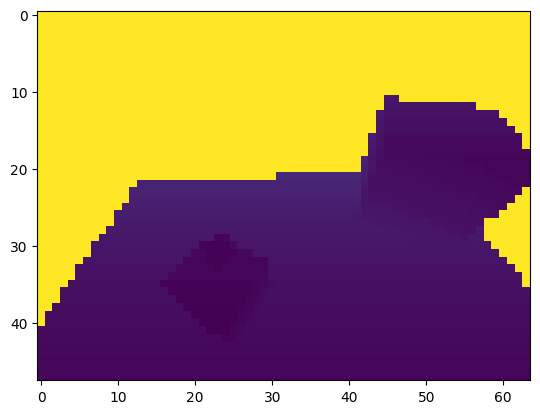

In [124]:
plt.imshow(gt_trace.get_retval().rendered[..., 2])

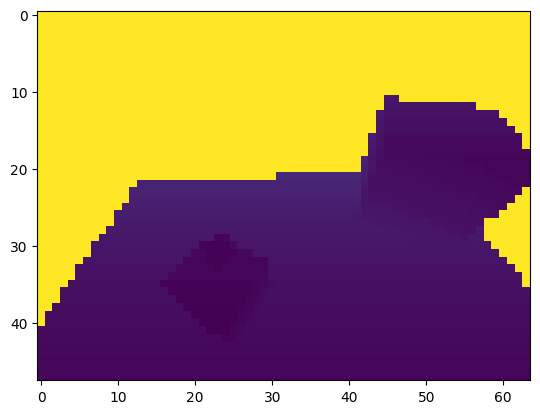

In [125]:
plt.imshow(gt_trace["image"][..., 2])

### Inference

In [126]:
obs_img = gt_trace.get_retval().rendered

In [127]:
from genjax import Diff, NoChange, UnknownChange

In [144]:
def update_choicemap(obj_idx, cat_idx, parent_idx):
    return genjax.choice_map({
        "objects": genjax.indexed_choice_map(
            jnp.array([obj_idx]),
            flat_choicemaps_to_vector_choicemap([obj_choicemap(
                cat_idx, parent_idx, jnp.zeros(3)
            )])
        )
    })

def add_object(tr, cat_idx, parent_idx):
    n_objects = tr.get_args()[1]
    nochange_args = tuple(map(lambda v: Diff(v, NoChange), tr.get_args()))
    new_args = (nochange_args[0], Diff(n_objects+1, UnknownChange), *nochange_args[2:])
    newtr, _, _, _ = tr.update(
        key,
        update_choicemap(n_objects, cat_idx, parent_idx),
        new_args)
    return newtr

In [155]:
grid_params_wide = [
    (0.65, jnp.pi, (30,30,15)),
    (0.2, jnp.pi, (15,15,15)),
    (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi, (15,15,15)),
    (0.02, jnp.pi, (9,9,51)),
    (0.01, jnp.pi/5, (15, 15, 15))
]

contact_param_gridding_schedule_wide = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params_wide
]

In [156]:
grid_params_narrow = [
    (0.15, jnp.pi, (30,30,15)),
    (0.08, jnp.pi, (15,15,15)),
    (0.04, jnp.pi, (15,15,15)),
    (0.02, jnp.pi, (9,9,51)),
    (0.01, jnp.pi/5, (15, 15, 15))
]

contact_param_gridding_schedule_narrow = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params_narrow
]

In [145]:
def cp_choicemap(object_idx, v):
    return genjax.choice_map({
            "objects": genjax.indexed_choice_map(
                jnp.array([object_idx]),
                flat_choicemaps_to_vector_choicemap([genjax.choice_map({"contact_params": v})])
            )
        })
def _c2f(key, tr, object_idx, contact_param_gridding_schedule):
    updater = jax.jit(jax.vmap(lambda trace, v: trace.update(
        key, cp_choicemap(object_idx, v)
    )[0].get_score(), in_axes=(None, 0)))
    cp = tr.get_retval().object_info.params[object_idx, ...]
    for cp_grid in contact_param_gridding_schedule:
        cps = cp + cp_grid
        scores = updater(tr, cps)
        cp = cps[jnp.argmax(scores)]
        # i = jax.random.randint(key, (1,), 0, len(scores))[0]
        # cp = cps[i]
    potential_trace = tr.update(key, cp_choicemap(object_idx, cp))[0]
    return potential_trace

c2f = jax.jit(_c2f)

In [146]:
def _extend_then_c2f(key, tr, cat_idx, parent_idx, contact_param_gridding_schedule):
    return c2f(
        key,
        add_object(tr, cat_idx, parent_idx),
        tr.get_args()[1],
        contact_param_gridding_schedule
    )
extend_then_c2f = jax.jit(_extend_then_c2f)

In [147]:
constraints_t1 = genjax.choice_map({
    "camera_pose": jnp.eye(4),
    "objects": genjax.indexed_choice_map(
        jnp.arange(1),
        flat_choicemaps_to_vector_choicemap([table_choicemap])
    ),
    "variance": 0.02,
    "outlier_prob": 0.0005,
    "image": obs_img
})

In [148]:
key, _ = jax.random.split(key)
model_args_t1 = (model_args[0], 1, *model_args[2:])
tr1, _ = model.importance(key, constraints_t1, model_args_t1)

In [160]:
viz_trace_meshcat(tr1)

In [161]:
tr2 = extend_then_c2f(key, tr1, 3, 0, contact_param_gridding_schedule_wide)
viz_trace_meshcat(tr2)

In [162]:
tr3 = extend_then_c2f(key, tr2, 2, 0, contact_param_gridding_schedule_wide)
viz_trace_meshcat(tr3)

In [163]:
tr4 = extend_then_c2f(key, tr3, 1, 2, contact_param_gridding_schedule_narrow)
viz_trace_meshcat(tr4)

In [181]:
def run_inference(key, tr, n_objects_to_add):
    for _ in range(n_objects_to_add):
        n_objects = tr.get_args()[1]
        trs0 = [
            extend_then_c2f(key, tr, cat, 0, contact_param_gridding_schedule_wide)
            for cat in [3, 2, 1]
        ]
        trsi = []
        for i in range(1, n_objects):
            trs_i = [
                extend_then_c2f(key, tr, cat, i, contact_param_gridding_schedule_narrow)
                for cat in [3, 2, 1]
            ]
            trsi.append(trs_i)
        all_trs_flat = trs0 + [t for ts in trsi for t in ts]
        scores = jnp.array([tr.get_score() for tr in all_trs_flat])
        tr = all_trs_flat[jnp.argmax(scores)]
    return tr

In [184]:
tr2 = run_inference(key, tr1, 3)

In [185]:
viz_trace_meshcat(tr2)